# Importing libraries

In [ ]:
! pip install medmnist keras_tuner -q

     |████████████████████████████████| 135 kB 45.0 MB/s 
     |████████████████████████████████| 87 kB 6.5 MB/s 
     |████████████████████████████████| 1.6 MB 60.0 MB/s 


# Setup

In [ ]:
from sklearn.model_selection import KFold

import tensorflow as tf
import keras_tuner as kt

import medmnist
from medmnist import INFO
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NUMFEATURES = 28 * 28 * 3 # = 2352
NUMCLASSES = 8

# importing  BloodMNIST
info = INFO['bloodmnist']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor()
])

# raw data
train_dataset = DataClass(
    split='train', transform=data_transform, download=True)
val_dataset = DataClass(
    split='val', transform=data_transform, download=True)

# preprocessing data
x_train = train_dataset.imgs / 255
y_train = train_dataset.labels

x_val = val_dataset.imgs / 255
y_val = val_dataset.labels

#training data
x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))

print(f'shape of x_train: {x_train.shape}; x_val: {x_val.shape}')

  0%|          | 0/35461855 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
shape of x_train: (11959, 28, 28, 3); x_val: (1712, 28, 28, 3)


# Building the mini DenseNet

In [ ]:
def densenet(input_shape, n_classes, filters=16, training=None):
    
    #batch norm + relu + conv
    def bn_rl_conv(x, filters, kernel=1, strides=1):
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters) # In dense block, each of the 1x1 convolutions has 4 times the number of filters
            y = bn_rl_conv(y, filters, 3)
            x = tf.keras.layers.concatenate([y,x])
        return x
        
    def transition_layer(x):
        channels = tf.keras.backend.int_shape(x)[-1]
        x = bn_rl_conv(x, channels//2) #1x1 conv halving the number of channels
        x = tf.keras.layers.AvgPool2D(2, strides=2, padding='same')(x)
        return x
    
    #first layer
    input = tf.keras.Input(input_shape)
    x = tf.keras.layers.Dropout(rate=0.0)(input)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    for repetition in [6,12,8]:
        d = dense_block(x, repetition)
        x = transition_layer(d)

    x = tf.keras.layers.GlobalAveragePooling2D()(d)
    output = tf.keras.layers.Dense(NUMCLASSES, activation='softmax')(x)
    
    model = tf.keras.Model(input, output)
    return model


input_shape = (28, 28, 3)
model = densenet(input_shape, NUMCLASSES)
#model.summary()

In [ ]:
# fitting the model
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
model.fit(x=x_all,
          y=y_all,
          batch_size=32,
          epochs=30,)

Epoch 1/30
428/428 [==============================] - 31s 29ms/step - loss: 0.6095 - accuracy: 0.7785
Epoch 2/30
428/428 [==============================] - 11s 26ms/step - loss: 0.3890 - accuracy: 0.8566
Epoch 3/30
428/428 [==============================] - 11s 27ms/step - loss: 0.3207 - accuracy: 0.8792
Epoch 4/30
428/428 [==============================] - 11s 27ms/step - loss: 0.2904 - accuracy: 0.8939
Epoch 5/30
428/428 [==============================] - 12s 27ms/step - loss: 0.2492 - accuracy: 0.9104
Epoch 6/30
428/428 [==============================] - 12s 29ms/step - loss: 0.2352 - accuracy: 0.9140
Epoch 7/30
428/428 [==============================] - 11s 26ms/step - loss: 0.2038 - accuracy: 0.9278
Epoch 8/30
428/428 [==============================] - 11s 26ms/step - loss: 0.1910 - accuracy: 0.9308
Epoch 9/30
428/428 [==============================] - 11s 27ms/step - loss: 0.1783 - accuracy: 0.9353
Epoch 10/30
428/428 [==============================] - 11s 26ms/step - loss: 0.164

# Testing the model

In [ ]:
# obtaining the test dataset
test_dataset = DataClass(
    split='test', transform=data_transform, download=True)

x_test = test_dataset.imgs / 255
y_test = test_dataset.labels

print(x_test.shape)
print(y_test.shape)

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
(3421, 28, 28, 3)
(3421, 1)


#Results

In [ ]:
# metrics
print(model.metrics_names)
print(model.evaluate(x_test, y_test))

['loss', 'accuracy']
107/107 [==============================] - 2s 12ms/step - loss: 0.6973 - accuracy: 0.8398
[0.6973111033439636, 0.8398129343986511]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


107/107 [==============================] - 2s 8ms/step


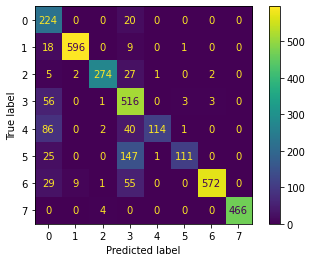

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# confusion matrix
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

labels = ['basofilos', 'eosinofilos', 'eritroblastos', 'granulocitos', 'linfocitos', 'monocitos', 'neutrofilos', 'plaquetas']
classifier = estimator(model, classes=labels)
plot_confusion_matrix(estimator=classifier, X=x_test, y_true=y_test)

#Analysing the mistakes

In [ ]:
# getting the predictions
probs = model.predict(x_test)
predictions = [np.argmax(probs[i]) for i in range(len(probs))]

107/107 [==============================] - 1s 8ms/step


In [ ]:
# getting mistakes
mistakes_index = []
incorrect_labels = []
for i in range(len(predictions)):
  if predictions[i] != y_test[i]:
    incorrect_labels.append(predictions[i])
    mistakes_index.append(i)

print(f'from {len(predictions)} entries, the model misclassified {len(mistakes_index)}')

from 3421 entries, the model misclassified 548


In [ ]:
# printing errors

for index in range(15):
  correct_index = mistakes_index[index]
  print(f'index: {mistakes_index[index]} - misclassified as {incorrect_labels[index]}; correct label is {y_test[correct_index]}')

index: 9 - misclassified as 0; correct label is [1]
index: 14 - misclassified as 3; correct label is [2]
index: 15 - misclassified as 0; correct label is [4]
index: 16 - misclassified as 2; correct label is [4]
index: 19 - misclassified as 3; correct label is [4]
index: 23 - misclassified as 0; correct label is [5]
index: 30 - misclassified as 0; correct label is [1]
index: 33 - misclassified as 3; correct label is [5]
index: 35 - misclassified as 0; correct label is [6]
index: 37 - misclassified as 3; correct label is [5]
index: 50 - misclassified as 3; correct label is [5]
index: 62 - misclassified as 2; correct label is [6]
index: 69 - misclassified as 4; correct label is [2]
index: 73 - misclassified as 0; correct label is [4]
index: 78 - misclassified as 0; correct label is [6]


incorrect label: 0; correct label: 3


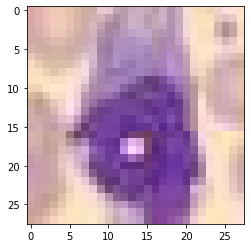

In [ ]:
plt.imshow(x_test[101], cmap="Greys_r")
print('incorrect label: 0; correct label: 3')